## ESN example

计算谱半径...
Wout
(1, 1002)
MSE = 0.00014603213361021462


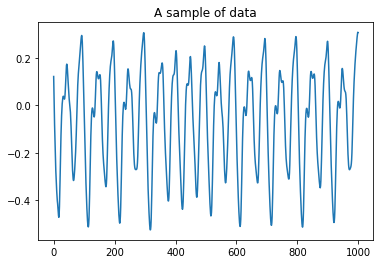

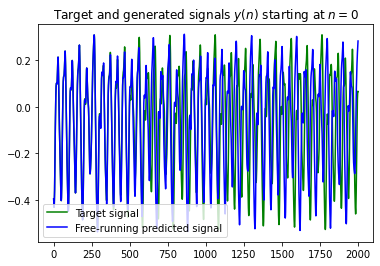

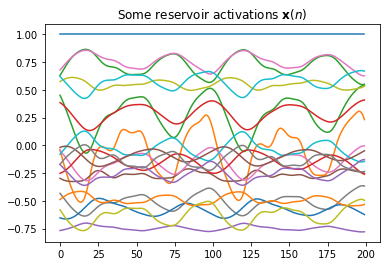

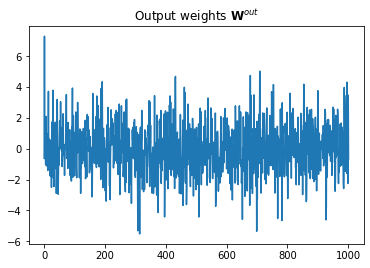

In [10]:
from numpy import *
from matplotlib.pyplot import *
import scipy.linalg
import matplotlib.pyplot as plt
 
# 加载数据
# 前2000个数据用来训练，2001-4000的数据用来测试。训练数据中，前100项用来初始化储备池，以让储备池中形成良好的回声之后再开始训练。
trainLen = 2000
testLen = 2000
initLen = 100  # 前100项用来初始化储备池
 
data = loadtxt('MackeyGlass_t17.txt')
 
# 绘制前1000条数据
figure(0).clear()
plot(data[0:1000])
title('A sample of data')
 
# 生成ESN储层
inSize = outSize = 1  # inSize 输入维数 K
resSize = 1000  # 储备池规模 N
a = 0.3  # 可以看作储备池更新的速度，可不加，即设为1.
 
random.seed(42)
# 随机初始化 Win 和 W
Win = (random.rand(resSize, 1 + inSize) - 0.5) * 1  # 输入矩阵 N * 1+K
W = random.rand(resSize, resSize) - 0.5  # 储备池连接矩阵 N * N
 
# 对W进行防缩，以满足稀疏的要求。
# 方案 1 - 直接缩放 (快且有脏数据, 特定储层): W *= 0.135
# 方案 2 - 归一化并设置谱半径 (正确, 慢):
print('计算谱半径...')
rhoW = max(abs(linalg.eig(W)[0]))  # linalg.eig(W)[0]:特征值   linalg.eig(W)[1]:特征向量
W *= 0.9 / rhoW
# 为设计（收集状态）矩阵分配内存
X = zeros((1 + inSize + resSize, trainLen - initLen))  # 储备池的状态矩阵x(t)：每一列是每个时刻的储备池状态。后面会转置
# 直接设置相应的目标矩阵
Yt = data[None, initLen + 1:trainLen + 1]  # 输出矩阵:每一行是一个时刻的输出
 
# 输入所有的训练数据，然后得到每一时刻的输入值和储备池状态。
x = zeros((resSize, 1))
for t in range(trainLen):
    u = data[t]
    x = (1 - a) * x + a * tanh(dot(Win, vstack((1, u))) + dot(W, x))  # vstack((1, u)):将偏置量1加入输入序列
    if t >= initLen:  # 空转100次后，开始记录储备池状态
        X[:, t - initLen] = vstack((1, u, x))[:, 0]
 
# 使用Wout根据输入值和储备池状态去拟合目标值，这是一个简单的线性回归问题，这里使用的是岭回归(Ridge Regression)。
reg = 1e-8  # 正则化系数
X_T = X.T
# Wout:  1 * 1+K+N
Wout = dot(dot(Yt, X_T), linalg.inv(dot(X, X_T) + \
                                    reg * eye(1 + inSize + resSize)))  # linalg.inv矩阵求逆；numpy.eye()生成对角矩阵，规模:1+inSize+resSize，默认对角线全1，其余全0
# Wout = dot( Yt, linalg.pinv(X) )
# print("Wout")
# print(Wout.shape)
# 使用训练数据进行前向处理得到结果
# run the trained ESN in a generative mode. no need to initialize here,
# because x is initialized with training data and we continue from there.
Y = zeros((outSize, testLen))
u = data[trainLen]
for t in range(testLen):
    x = (1 - a) * x + a * tanh(dot(Win, vstack((1, u))) + dot(W, x))
    y = dot(Wout, vstack((1, u, x)))  # 输出矩阵(1 * 1+K+N)*此刻状态矩阵(1+K+N * 1)=此刻预测值
    Y[:, t] = y  # t时刻的预测值   Y: 1 * testLen
    # 生成模型
    u = y
    # 预测模型
    # u = data[trainLen+t+1]
 
# 计算第一个errorLen时间步长的MSE
errorLen = 500
mse = sum(square(data[trainLen + 1:trainLen + errorLen + 1] - Y[0, 0: errorLen])) / errorLen
print('MSE = {0}'.format(str(mse)))
 
# 绘制测试集的真实数据和预测数据
figure(1).clear()
plot(data[trainLen + 1:trainLen + testLen + 1], 'g')
plot(Y.T, 'b')
title('Target and generated signals $y(n)$ starting at $n=0$')
legend(['Target signal', 'Free-running predicted signal'])
 
# 绘制储备池中前200个时刻状态(x(t))的前20个储层结点值
figure(2).clear()
plot(X[0:20, 0:200].T)
title('Some reservoir activations $\mathbf{x}(n)$')
 
# 绘制输出矩阵
figure(3).clear()
# bar(np.arange(1 + inSize + resSize), Wout.T, 8)
plot(np.arange(1 + inSize + resSize), Wout.T)
 
title('Output weights $\mathbf{W}^{out}$')
show()

In [15]:
data = loadtxt('MackeyGlass_t17.txt')


## ESN module

In [119]:
class esn():
        def __init__(self, inSize, outSize, resSize, a):
            # sample length define
            self.trainLen = 1000
            self.testLen = 2000
            self.initLen = 100
            #  hyper parameters
            self.inSize = inSize
            self.outSize = outSize
            self.resSize = resSize
            self.a = a
            # initialize Win and W
            random.seed(42)
            self.Win = (random.rand(resSize, 1 + inSize) - 0.5) * 1  # 输入矩阵 N * 1+K
            self.W = random.rand(resSize, resSize) - 0.5  # 储备池连接矩阵 N * N
            self.Wout = zeros((1 + inSize + resSize))
            print('计算谱半径...')
            rhoW = max(abs(linalg.eig(self.W)[0]))  # linalg.eig(W)[0]:特征值   linalg.eig(W)[1]:特征向量
            self.W *= 0.9 / rhoW

            # reservior initialize
            self.x = zeros((resSize, 1))

        def train(self, data_in, data_out):
            X = zeros((1 + self.inSize + self.resSize, self.trainLen - self.initLen))  # 储备池的状态矩阵x(t)：每一列是每个时刻的储备池状态。后面会转置
            # 直接设置相应的目标矩阵
            Yt = data_out[:, self.initLen:self.trainLen + 1]  # 输出矩阵:每一行是一个时刻的输出
            for t in range(self.trainLen):
                u = data_in[:,t].reshape(-1, 1)
                self.x = (1 - self.a) * self.x + self.a * tanh(dot(self.Win, vstack((1, u))) + dot(self.W, self.x))  # vstack((1, u)):将偏置量1加入输入序列
                if t >= initLen:  # 空转100次后，开始记录储备池状态
                    X[:, t - initLen] = vstack((1, u, self.x))[:, 0]
            reg = 1e-8  # 正则化系数
            X_T = X.T
            # Wout:  1 * 1+K+N
            self.Wout = dot(dot(Yt, X_T), linalg.inv(dot(X, X_T) + reg * eye(1 + self.inSize + self.resSize)))
            
            train_re = dot(X_T, self.Wout.T)
            
            return train_re

        def predict(self, data_in):
            testLen = data_in.shape[1]
            
            Y = zeros((self.outSize, testLen))
            
            for t in range(testLen):
                u = data_in[:,t].reshape(-1,1)
                self.x = (1 - self.a) * self.x + self.a * tanh(dot(self.Win, vstack((1, u))) + dot(self.W, self.x))
                y = dot(self.Wout, vstack((1, u, self.x)))  # 输出矩阵(1 * 1+K+N)*此刻状态矩阵(1+K+N * 1)=此刻预测值
                Y[:, t] = y[:,0]  # t时刻的预测值   Y: 1 * testLen
            return Y.T 
                # u = data[trainLen+t+1]

            # evaluate
#             errorLen = 500
#             mse = sum(square(data[self.trainLen + 1:self.trainLen + errorLen + 1] - Y[0, 0: errorLen])) / errorLen
#             print('MSE = {0}'.format(str(mse)))

In [9]:
cc = vstack((1, 2, 3))
cc.shape

(3, 1)

In [21]:
ESN = esn(1, 1, 1000, 0.3)

计算谱半径...


In [23]:
ESN.train(data)

In [24]:
ESN.predict(data)

MSE = 0.00014603213361021462


## data process module

In [33]:
from scipy.ndimage import convolve1d
class data_process():
    def __init__(self,data):
        self.data = data
        
    def moving_average(self, window_size = 7):
        signal = self.data
        # Create the window kernel
        kernel = np.ones(window_size) / window_size
        
        for i in range(signal.shape[1]):
            signal_per = signal[:,i]
            # Perform the moving average
            smoothed_signal = convolve1d(signal_per, kernel, mode='reflect')
            
            signal[:,i] = smoothed_signal
        return signal

## figure plot module

In [49]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
class figure_plot():
    def __init__(self, r, c, y_t):
        self.fig = make_subplots(rows=r , cols=c, y_title=y_t)
        self.rows = r
        self.cols = c
        
    def plot(self,data,lineWidth,subtitle):
        x_length = data.shape[0]
        input_time = np.arange(x_length)/(x_length-1)
        for i in np.arange(self.rows):
            self.fig.add_trace(go.Scatter(x=input_time, y=data[:,i], mode='lines',line=dict(width=lineWidth), name=subtitle[i]), row=i+1, col=1)
    
    def show(self):
        self.fig.update_layout(title='ESN layer training results (MI=0.10) (Sample 1)', showlegend=True,title_x=0.5, title_y=0.9,)
        for i in range(self.rows-1):
            self.fig.update_xaxes(row=i, col=1, showticklabels=False)
        
        self.fig.update_xaxes(title_text="Time step", row=self.rows, col=1)
        self.fig.show()

### ESN module test1

In [29]:
net_input = np.load("net_input_s1.npy")
net_target = np.load("net_target_s1.npy")


(1000, 3)

In [51]:
## data process module 
dp = data_process(net_target)
ntt = dp.moving_average()
## data plot module
fp = figure_plot(3,1,'net_target')
fp.plot(ntt,2,["GRF_X","GRF_Y","GRF_Z"])
fp.show()
## reshape and prepare feed into the esn layer
train_input = net_input.T
train_output = ntt.T

In [35]:
ntt.shape

(1000, 3)

In [86]:
train_input.shape

(4, 1000)

In [120]:
ESN_2 = esn(4, 3, 100, 0.3)
net_t = ESN_2.train(train_input, train_output)
net_p = ESN_2.predict(train_input)
net_p.shape

计算谱半径...


(1000, 3)

In [121]:
fp1 = figure_plot(3,1,'net_train')
fp1.plot(net_t,2,["GRF_X","GRF_Y","GRF_Z"])
fp1.show()

In [113]:
fp2 = figure_plot(3,1,'net_predict')
fp2.plot(net_p,2,["GRF_X","GRF_Y","GRF_Z"])
fp2.show()

In [114]:
test_in = np.load("torque_for_test_s1.npy").T

In [117]:
net_p2 = ESN_2.predict(test_in)

In [118]:
fp2 = figure_plot(3,1,'net_predict2')
fp2.plot(net_p2,2,["GRF_X","GRF_Y","GRF_Z"])
fp2.show()